# 04 - Bias Reduction Evaluation (CORRECTED)

## CORRECT APPROACH:
1. Load **ratings_enriched.csv** (ratings + TMDB metadata)
2. Test **each of 10 strategies individually**:
   - Apply bias reduction → feature engineering → train → evaluate
3. Select strategies that beat baseline
4. Apply selected strategies **combined**
5. Final comparison report

This ensures features and target are consistent (both from bias-reduced ratings).

In [11]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib

# Import modules
from src.bias_reduction import BiasReducer
from src.feature_engineering import engineer_features

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
PALETTE_5 = ['#008080', '#40B0A0', '#FFA500', '#696969', '#F0E68C']

DATA_PROCESSED = Path('../data/processed')
MODELS_DIR = Path('../models')

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Data

In [3]:
# Load ratings with TMDB metadata (has userId, movieId, rating, timestamp + all TMDB fields)
ratings_enriched = pd.read_csv(DATA_PROCESSED / 'ratings_enriched.csv')

# Load enriched movies (for BiasReducer - needs genres info)
movies_enriched = pd.read_csv(DATA_PROCESSED / 'movies_enriched.csv')

print(f"Ratings enriched: {len(ratings_enriched):,} rows, {len(ratings_enriched.columns)} columns")
print(f"Movies enriched: {len(movies_enriched):,} movies")
print(f"\nRatings columns: {list(ratings_enriched.columns)}")

GLOBAL_MEAN = ratings_enriched['rating'].mean()
print(f"\nGlobal mean: {GLOBAL_MEAN:.3f}")

Ratings enriched: 100,836 rows, 21 columns
Movies enriched: 9,734 movies

Ratings columns: ['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'tmdbId', 'director', 'cast', 'country', 'runtime', 'budget', 'revenue', 'release_date', 'original_language', 'vote_average', 'vote_count', 'popularity', 'tagline', 'overview', 'tags']

Global mean: 3.502


## 2. Model Training Function

In [13]:
def train_stacked_ensemble(X_train, y_train, X_test, y_test):
    """Train stacked ensemble model with shuffled CV for reproducibility."""
    estimators = [
        ('xgb', xgb.XGBRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=1.0,
            random_state=42, n_jobs=-1, tree_method='hist'
        )),
        ('lgb', lgb.LGBMRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbose=-1
        )),
        ('cat', CatBoostRegressor(
            iterations=200, depth=6, learning_rate=0.1,
            random_seed=42, verbose=0
        )),
        ('gb', GradientBoostingRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            subsample=0.8, random_state=42
        ))
    ]
    
    # Create shuffled KFold for reproducible CV regardless of row order
    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    
    model = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=cv_splitter,
        n_jobs=-1,
        passthrough=False
    )
    
    print("    Training stacked ensemble (5-fold shuffled CV)...")
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'train_rmse': float(np.sqrt(mean_squared_error(y_train, y_train_pred))),
        'test_rmse': float(np.sqrt(mean_squared_error(y_test, y_test_pred))),
        'train_mae': float(mean_absolute_error(y_train, y_train_pred)),
        'test_mae': float(mean_absolute_error(y_test, y_test_pred)),
        'train_r2': float(r2_score(y_train, y_train_pred)),
        'test_r2': float(r2_score(y_test, y_test_pred))
    }
    
    return model, metrics

print("✓ Training function defined")

✓ Training function defined


## 3. Test ALL Strategies Individually

Test baseline + all 10 bias reduction strategies one by one.

In [5]:
# All strategies available in BiasReducer
all_strategies = [
    'implicit_negatives',
    'binary',
    'zscore',
    'temporal',
    'genre_deviation',
    'popularity',
    'expectation',
    'review_bombing',
    'cinephile',
    'collaborative'
]

print(f"Testing {len(all_strategies)} individual strategies + baseline")
print("="*80)

Testing 10 individual strategies + baseline


In [6]:
%%time

all_results = []

# Test baseline first
print("\n[BASELINE]")
print("  No bias reduction")

print("  Feature engineering...")
X, y = engineer_features(ratings_enriched, GLOBAL_MEAN)
print(f"    ✓ {X.shape[1]} features, {len(X):,} samples")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, metrics = train_stacked_ensemble(X_train, y_train, X_test, y_test)

metrics['strategy'] = 'baseline'
all_results.append(metrics)

print(f"  ✓ Test RMSE: {metrics['test_rmse']:.4f}")
print(f"  ✓ Test MAE:  {metrics['test_mae']:.4f}")
print(f"  ✓ Test R²:   {metrics['test_r2']:.4f}")

baseline_rmse = metrics['test_rmse']

# Test each strategy individually
for strategy_name in all_strategies:
    print(f"\n[{strategy_name.upper()}]")
    
    try:
        # Apply single strategy
        print(f"  Applying: {strategy_name}")
        
        # Extract core columns for BiasReducer
        ratings_core = ratings_enriched[['userId', 'movieId', 'rating', 'timestamp']].copy()
        
        reducer = BiasReducer(ratings_core, movies_enriched)
        ratings_transformed = reducer.apply_strategies([strategy_name])
        
        # Merge bias-reduced ratings back with metadata
        df_with_metadata = ratings_enriched.drop(columns=['rating']).merge(
            ratings_transformed[['userId', 'movieId', 'rating']],
            on=['userId', 'movieId'],
            how='inner'
        )
        
        # Feature engineering
        print("  Feature engineering...")
        X, y = engineer_features(df_with_metadata, GLOBAL_MEAN)
        print(f"    ✓ {X.shape[1]} features, {len(X):,} samples")
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train
        model, metrics = train_stacked_ensemble(X_train, y_train, X_test, y_test)
        
        metrics['strategy'] = strategy_name
        all_results.append(metrics)
        
        improvement = (baseline_rmse - metrics['test_rmse']) / baseline_rmse * 100
        
        print(f"  ✓ Test RMSE: {metrics['test_rmse']:.4f} ({improvement:+.2f}% vs baseline)")
        print(f"  ✓ Test MAE:  {metrics['test_mae']:.4f}")
        print(f"  ✓ Test R²:   {metrics['test_r2']:.4f}")
        
    except Exception as e:
        print(f"  ✗ ERROR: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("INDIVIDUAL STRATEGY TESTING COMPLETE")
print("="*80)


[BASELINE]
  No bias reduction
  Feature engineering...
    ✓ 106 features, 100,836 samples
    Training stacked ensemble...
  ✓ Test RMSE: 0.7244
  ✓ Test MAE:  0.5405
  ✓ Test R²:   0.5230

[IMPLICIT_NEGATIVES]
  Applying: implicit_negatives
  Feature engineering...
    ✓ 106 features, 100,836 samples
    Training stacked ensemble...
  ✓ Test RMSE: 0.7244 (+0.00% vs baseline)
  ✓ Test MAE:  0.5405
  ✓ Test R²:   0.5230

[BINARY]
  Applying: binary
  Feature engineering...
    ✓ 106 features, 100,836 samples
    Training stacked ensemble...
  ✓ Test RMSE: 0.7775 (-7.33% vs baseline)
  ✓ Test MAE:  0.5786
  ✓ Test R²:   0.4872

[ZSCORE]
  Applying: zscore
  Feature engineering...
    ✓ 106 features, 100,836 samples
    Training stacked ensemble...
  ✓ Test RMSE: 0.7502 (-3.56% vs baseline)
  ✓ Test MAE:  0.5759
  ✓ Test R²:   0.4122

[TEMPORAL]
  Applying: temporal
  Feature engineering...
    ✓ 106 features, 100,836 samples
    Training stacked ensemble...
  ✓ Test RMSE: 0.7244 (+0.0

## 4. Select Best Strategies

In [7]:
# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_rmse')

print("Individual Strategy Results (sorted by Test RMSE):")
print("="*80)
print(results_df[['strategy', 'test_rmse', 'test_mae', 'test_r2']].to_string(index=False))

# Find strategies better than baseline
baseline_rmse = results_df[results_df['strategy'] == 'baseline']['test_rmse'].values[0]
better_than_baseline = results_df[
    (results_df['strategy'] != 'baseline') & 
    (results_df['test_rmse'] < baseline_rmse)
]

print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"\nStrategies better than baseline ({len(better_than_baseline)}):")
if len(better_than_baseline) > 0:
    for _, row in better_than_baseline.iterrows():
        improvement = (baseline_rmse - row['test_rmse']) / baseline_rmse * 100
        print(f"  - {row['strategy']}: {row['test_rmse']:.4f} ({improvement:+.2f}%)")
    
    best_strategy_list = better_than_baseline['strategy'].tolist()
else:
    print("  None - no strategies beat baseline")
    best_strategy_list = []

Individual Strategy Results (sorted by Test RMSE):
          strategy  test_rmse  test_mae  test_r2
       expectation   0.702034  0.525037 0.533638
         cinephile   0.718406  0.535823 0.515439
     collaborative   0.719447  0.537818 0.502391
        popularity   0.721851  0.538949 0.518443
    review_bombing   0.722501  0.539400 0.523956
          baseline   0.724407  0.540516 0.522958
implicit_negatives   0.724407  0.540516 0.522958
          temporal   0.724407  0.540516 0.522958
   genre_deviation   0.724407  0.540516 0.522958
            zscore   0.750161  0.575943 0.412242
            binary   0.777485  0.578606 0.487196

Baseline RMSE: 0.7244

Strategies better than baseline (5):
  - expectation: 0.7020 (+3.09%)
  - cinephile: 0.7184 (+0.83%)
  - collaborative: 0.7194 (+0.68%)
  - popularity: 0.7219 (+0.35%)
  - review_bombing: 0.7225 (+0.26%)


## 5. Test Combined Best Strategies

In [14]:
%%time

if len(best_strategy_list) > 0:
    print("\n" + "="*80)
    print("[COMBINED BEST STRATEGIES]")
    print("="*80)
    print(f"Combining: {', '.join(best_strategy_list)}")
    
    # Apply all best strategies together
    ratings_core = ratings_enriched[['userId', 'movieId', 'rating', 'timestamp']].copy()
    
    reducer = BiasReducer(ratings_core, movies_enriched)
    ratings_combined = reducer.apply_strategies(best_strategy_list)
    
    # Merge bias-reduced ratings back with metadata
    df_combined = ratings_enriched.drop(columns=['rating']).merge(
        ratings_combined[['userId', 'movieId', 'rating']],
        on=['userId', 'movieId'],
        how='inner'
    )
    
    # Feature engineering
    print("  Feature engineering...")
    X, y = engineer_features(df_combined, GLOBAL_MEAN)
    print(f"    ✓ {X.shape[1]} features, {len(X):,} samples")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train
    model_combined, metrics_combined = train_stacked_ensemble(X_train, y_train, X_test, y_test)
    
    metrics_combined['strategy'] = 'combined_best'
    all_results.append(metrics_combined)
    
    improvement = (baseline_rmse - metrics_combined['test_rmse']) / baseline_rmse * 100
    
    print(f"\n✓ Combined Results:")
    print(f"  Test RMSE: {metrics_combined['test_rmse']:.4f} ({improvement:+.2f}% vs baseline)")
    print(f"  Test MAE:  {metrics_combined['test_mae']:.4f}")
    print(f"  Test R²:   {metrics_combined['test_r2']:.4f}")
    
    # Save combined model
    print("\nSaving combined model...")
    joblib.dump(model_combined, MODELS_DIR / 'model_bias_reduced.pkl')
    
    # Save bias-reduced ratings (merge back with full metadata)
    ratings_to_save = ratings_enriched.drop(columns=['rating']).merge(
        ratings_combined[['userId', 'movieId', 'rating']],
        on=['userId', 'movieId'],
        how='inner'
    )
    ratings_to_save.to_csv(DATA_PROCESSED / 'ratings_bias_reduced.csv', index=False)
    
    print(f"  ✓ Saved to {MODELS_DIR / 'model_bias_reduced.pkl'}")
    print(f"  ✓ Saved to {DATA_PROCESSED / 'ratings_bias_reduced.csv'}")
else:
    print("\nNo strategies beat baseline - skipping combined model")


[COMBINED BEST STRATEGIES]
Combining: expectation, cinephile, collaborative, popularity, review_bombing
  Feature engineering...
    ✓ 106 features, 100,823 samples
    Training stacked ensemble (5-fold shuffled CV)...

✓ Combined Results:
  Test RMSE: 0.6932 (+4.31% vs baseline)
  Test MAE:  0.5187
  Test R²:   0.4950

Saving combined model...
  ✓ Saved to ../models/model_bias_reduced.pkl
  ✓ Saved to ../data/processed/ratings_bias_reduced.csv
CPU times: user 56.6 s, sys: 2.44 s, total: 59.1 s
Wall time: 10min 10s


## 6. Final Summary Report

In [9]:
# Final comparison
final_results = pd.DataFrame(all_results)
final_results = final_results.sort_values('test_rmse')

print("="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n1. ALL RESULTS (sorted by Test RMSE):")
print(final_results[['strategy', 'test_rmse', 'test_mae', 'test_r2']].to_string(index=False))

print(f"\n2. BASELINE:")
baseline = final_results[final_results['strategy'] == 'baseline'].iloc[0]
print(f"   Test RMSE: {baseline['test_rmse']:.4f}")
print(f"   Test MAE:  {baseline['test_mae']:.4f}")
print(f"   Test R²:   {baseline['test_r2']:.4f}")

print(f"\n3. BEST INDIVIDUAL STRATEGY:")
best_individual = final_results[
    (final_results['strategy'] != 'baseline') & 
    (final_results['strategy'] != 'combined_best')
].iloc[0]
improvement = (baseline_rmse - best_individual['test_rmse']) / baseline_rmse * 100
print(f"   Strategy: {best_individual['strategy']}")
print(f"   Test RMSE: {best_individual['test_rmse']:.4f} ({improvement:+.2f}% vs baseline)")
print(f"   Test MAE:  {best_individual['test_mae']:.4f}")
print(f"   Test R²:   {best_individual['test_r2']:.4f}")

if 'combined_best' in final_results['strategy'].values:
    print(f"\n4. COMBINED BEST STRATEGIES:")
    combined = final_results[final_results['strategy'] == 'combined_best'].iloc[0]
    improvement = (baseline_rmse - combined['test_rmse']) / baseline_rmse * 100
    print(f"   Strategies: {', '.join(best_strategy_list)}")
    print(f"   Test RMSE: {combined['test_rmse']:.4f} ({improvement:+.2f}% vs baseline)")
    print(f"   Test MAE:  {combined['test_mae']:.4f}")
    print(f"   Test R²:   {combined['test_r2']:.4f}")

# Save final results
final_results.to_csv(DATA_PROCESSED / 'bias_reduction_results.csv', index=False)
print(f"\n✓ Results saved to {DATA_PROCESSED / 'bias_reduction_results.csv'}")

print("\n" + "="*80)
print("BIAS REDUCTION EVALUATION COMPLETE")
print("="*80)

FINAL SUMMARY REPORT

1. ALL RESULTS (sorted by Test RMSE):
          strategy  test_rmse  test_mae  test_r2
     combined_best   0.693168  0.518747 0.494996
       expectation   0.702034  0.525037 0.533638
         cinephile   0.718406  0.535823 0.515439
     collaborative   0.719447  0.537818 0.502391
        popularity   0.721851  0.538949 0.518443
    review_bombing   0.722501  0.539400 0.523956
          baseline   0.724407  0.540516 0.522958
implicit_negatives   0.724407  0.540516 0.522958
          temporal   0.724407  0.540516 0.522958
   genre_deviation   0.724407  0.540516 0.522958
            zscore   0.750161  0.575943 0.412242
            binary   0.777485  0.578606 0.487196

2. BASELINE:
   Test RMSE: 0.7244
   Test MAE:  0.5405
   Test R²:   0.5230

3. BEST INDIVIDUAL STRATEGY:
   Strategy: expectation
   Test RMSE: 0.7020 (+3.09% vs baseline)
   Test MAE:  0.5250
   Test R²:   0.5336

4. COMBINED BEST STRATEGIES:
   Strategies: expectation, cinephile, collaborative, pop

## 7. Visualization

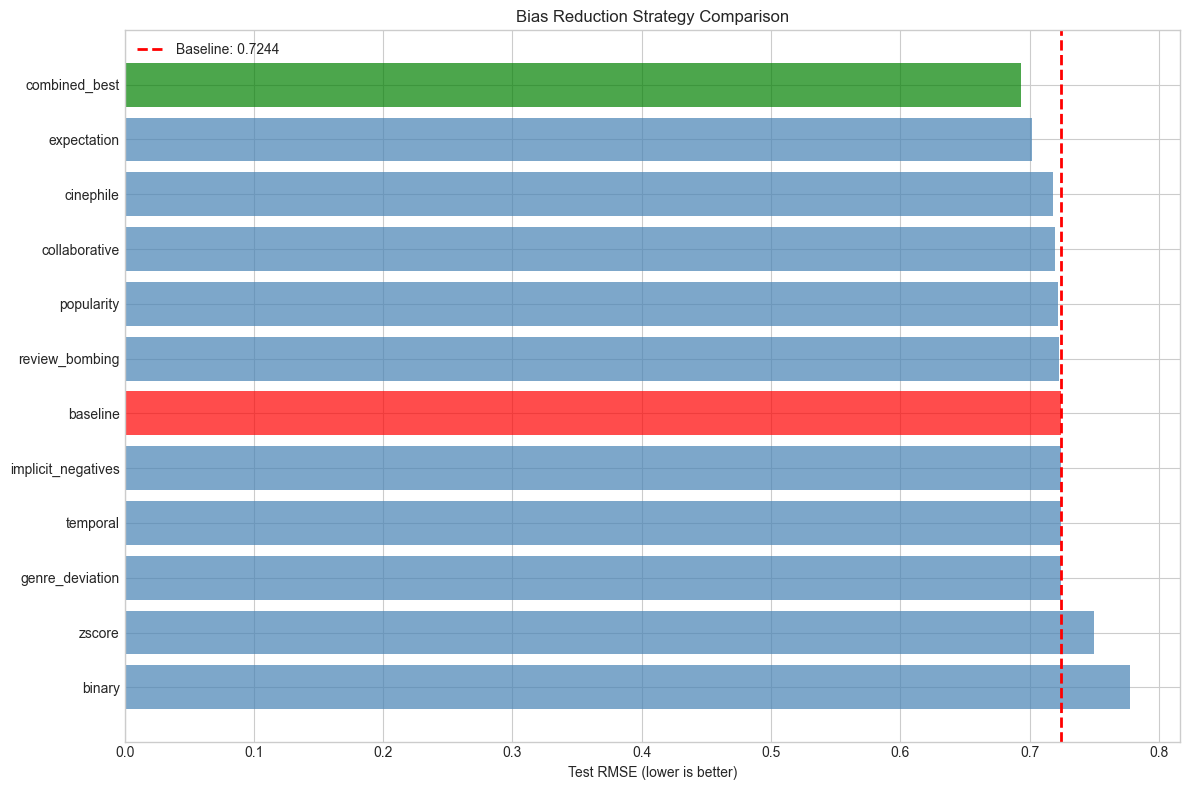

✓ Saved visualization to docs/bias_reduction_comparison.png


In [10]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

strategies = final_results['strategy'].tolist()
rmse_vals = final_results['test_rmse'].tolist()

colors = ['red' if s == 'baseline' else 'green' if s == 'combined_best' else 'steelblue' 
          for s in strategies]

ax.barh(strategies, rmse_vals, color=colors, alpha=0.7)
ax.axvline(baseline_rmse, color='red', linestyle='--', linewidth=2, 
           label=f'Baseline: {baseline_rmse:.4f}')
ax.set_xlabel('Test RMSE (lower is better)')
ax.set_title('Bias Reduction Strategy Comparison')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../docs/bias_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization to docs/bias_reduction_comparison.png")